<a href="https://colab.research.google.com/github/ucalyptus/fastai-notebooks/blob/master/Sayantan_does_lesson3_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-label prediction with Planet Amazon dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
# ! pip install kaggle --upgrade

In [3]:
!pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 3.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/ee/97/c5/87dcdc9434fe4e632ed5945e31a03703af229db178ef6a00e8
Successfully built kaggle
  Found existing installation: kaggle 1.5.2
    Uninstalling kaggle-1.5.2:
      Successfully uninstalled kaggle-1.5.2


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [5]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [6]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

100% 599M/600M [00:04<00:00, 95.4MB/s]
100% 600M/600M [00:04<00:00, 127MB/s] 
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 72.3MB/s]


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [7]:
!wget -c https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.2.0-Linux-x86_64.sh
!bash ./Anaconda3-5.2.0-Linux-x86_64.sh -b -f -p /usr/local

--2019-02-24 15:18:10--  https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 651745206 (622M) [application/x-sh]
Saving to: ‘Anaconda3-5.2.0-Linux-x86_64.sh’

Anaconda3-5.2.0-Lin 100%[===================>] 621.55M   127MB/s    in 4.8s    

2019-02-24 15:18:15 (130 MB/s) - ‘Anaconda3-5.2.0-Linux-x86_64.sh’ saved [651745206/651745206]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: blas-1.0-mkl ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: intel-openmp-2018.0.0-8 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libgfortran-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: bzip2-1.0.6

In [8]:
!conda install -y -c haasad eidl7zip
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [10]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Signature: get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
Source:   
def get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if do_flip:    res.append(dihedral_affine() if flip_vert else flip_affine(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if max_zoom>1: res.append(rand_zoom(scale=(1.,max_zoom), p=p_affine))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad()])
File:      /usr/local/lib/python3.6/dist-packages/fastai/vision/transform.py
Type:      function

In [0]:
get_transforms??

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

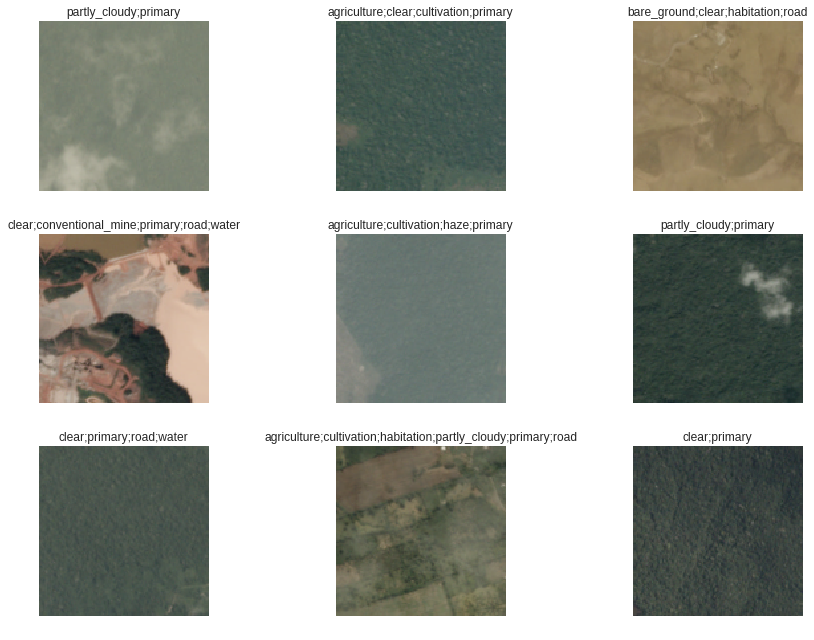

In [14]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [16]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 78308719.78it/s]


In [0]:
partial??

Init signature: partial(self, /, *args, **kwargs)
Source:        
class partial:
    """New function with partial application of the given arguments
    and keywords.
    """

    __slots__ = "func", "args", "keywords", "__dict__", "__weakref__"

    def __new__(*args, **keywords):
        if not args:
            raise TypeError("descriptor '__new__' of partial needs an argument")
        if len(args) < 2:
            raise TypeError("type 'partial' takes at least one argument")
        cls, func, *args = args
        if not callable(func):
            raise TypeError("the first argument must be callable")
        args = tuple(args)

        if hasattr(func, "func"):
            args = func.args + args
            tmpkw = func.keywords.copy()
            tmpkw.update(keywords)
            keywords = tmpkw
            del tmpkw
            func = func.func

        self = super(partial, cls).__new__(cls)

        self.func = func
        self.args = args
        self.keywords = keywords
        return self

    def __call__(*args, **keywords):
        if not args:
            raise TypeError("descriptor '__call__' of partial needs an argument")
        self, *args = args
        newkeywords = self.keywords.copy()
        newkeywords.update(keywords)
        return self.func(*self.args, *args, **newkeywords)

    @recursive_repr()
    def __repr__(self):
        qualname = type(self).__qualname__
        args = [repr(self.func)]
        args.extend(repr(x) for x in self.args)
        args.extend(f"{k}={v!r}" for (k, v) in self.keywords.items())
        if type(self).__module__ == "functools":
            return f"functools.{qualname}({', '.join(args)})"
        return f"{qualname}({', '.join(args)})"

    def __reduce__(self):
        return type(self), (self.func,), (self.func, self.args,
               self.keywords or None, self.__dict__ or None)

    def __setstate__(self, state):
        if not isinstance(state, tuple):
            raise TypeError("argument to __setstate__ must be a tuple")
        if len(state) != 4:
            raise TypeError(f"expected 4 items in state, got {len(state)}")
        func, args, kwds, namespace = state
        if (not callable(func) or not isinstance(args, tuple) or
           (kwds is not None and not isinstance(kwds, dict)) or
           (namespace is not None and not isinstance(namespace, dict))):
            raise TypeError("invalid partial state")

        args = tuple(args) # just in case it's a subclass
        if kwds is None:
            kwds = {}
        elif type(kwds) is not dict: # XXX does it need to be *exactly* dict?
            kwds = dict(kwds)
        if namespace is None:
            namespace = {}

        self.__dict__ = namespace
        self.func = func
        self.args = args
        self.keywords = kwds
File:           /usr/lib/python3.6/functools.py
Type:           type

We use the LR Finder to pick a good learning rate.

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02


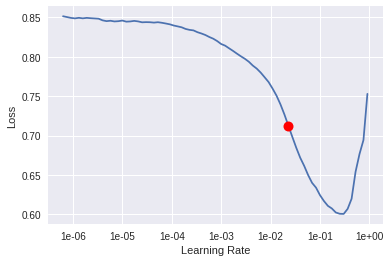

In [18]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.125979,0.112614,0.947106,0.899822
2,0.111862,0.097166,0.951880,0.915389
3,0.103363,0.091335,0.954998,0.921547
4,0.097272,0.088110,0.956080,0.924600
5,0.089963,0.087404,0.956240,0.924941


In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


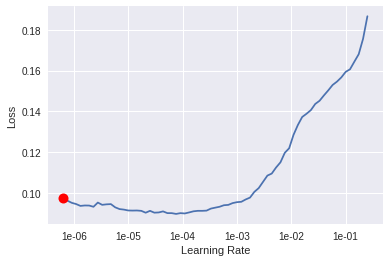

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.096074,0.093688,0.950492,0.918460
2,0.095242,0.089459,0.953602,0.921532
3,0.092292,0.085196,0.956378,0.926777
4,0.086000,0.083042,0.956582,0.928227
5,0.080123,0.082451,0.959118,0.929639


In [0]:
learn.save('stage-2-rn50')

In [44]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06


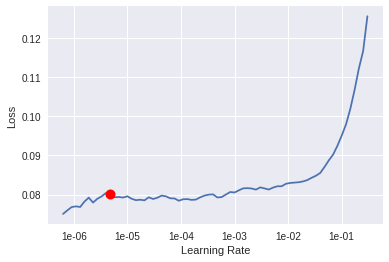

In [27]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [29]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.079744,0.085782,0.958718,0.924092
2,0.085104,0.084930,0.957563,0.928617
3,0.083759,0.084440,0.959242,0.928477
4,0.081504,0.082871,0.958900,0.929643
5,0.078812,0.083447,0.960353,0.929904


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [52]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.084015,0.083789,0.957439,0.928411
2,0.088878,0.084019,0.957432,0.928745
3,0.084277,0.081879,0.956916,0.928996
4,0.079039,0.080616,0.959866,0.930686
5,0.075382,0.081458,0.959198,0.931273


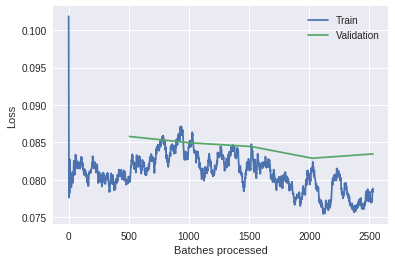

In [32]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [0]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [0]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [35]:
test = ImageItemList.from_folder(path/'test-jpg').add(ImageItemList.from_folder(path/'test-jpg-additional'))
len(test)

1

In [36]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

IndexError: ignored

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)